## 概要
- Poseを使った異常検知をMNISTでテストしてみる

## モジュールのインポート

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from keras.datasets import mnist
from keras.layers import Input, Dense, Layer, BatchNormalization, Dropout
from keras.layers import Lambda, Conv2D, Flatten, MaxPooling2D
from keras.layers import Reshape, Conv2DTranspose, UpSampling2D
from keras.models import Model
from keras import backend as K
#from keras import objectives
from keras.losses import binary_crossentropy
from keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint, Callback
import tensorflow as tf
from scipy.stats import norm
from sklearn.model_selection import train_test_split

from glob import glob
from multiprocessing import Pool
import multiprocessing as mp
from tqdm import tqdm_notebook as tqdm
from time import time
import datetime
import os

Using TensorFlow backend.


## データの前処理

In [2]:
dirs_path = sorted(glob("../data/shogi_pose_dataset/*"))

In [3]:
flag = True
for dir_path in dirs_path:
    if flag:
        data_path = sorted(glob(os.path.join(dir_path, "*")))
        flag = False
    else:
        data_path += sorted(glob(os.path.join(dir_path, "*")))

In [4]:
def read_img(path):
    cv2.setNumThreads(0)
    img = cv2.imread(path, 0)
    size = 32
    
    
    # openposeのミスをできるだけ前処理で落とす
    try:
        x, w, y, h = trimming(img)
        margin = 16
        img_trim = img[y-margin:h+margin, x-margin:w+margin]
        height, width = img_trim.shape
        
        if (height < 150) or (width < 150):
            return np.zeros((size, size))
        
        # 膨張処理
        kernel = np.ones((6,6),np.uint8)
        img_trim = cv2.bitwise_not(img_trim) # 白(255)を膨張させるため反転
        img_dil = cv2.dilate(img_trim,kernel,iterations = 1)
        
        img_dil = cv2.resize(img_dil, (size, size))
        
        # 2値化
        _,img_bin = cv2.threshold(img_dil,0,1,cv2.THRESH_BINARY)
        
        return img_bin * 255.0
    except:
        return np.zeros((size, size))

In [5]:
def trimming(img):
    mask = img < 255
    x = np.where(np.sum(mask, axis=0) > 1)[0]
    y = np.where(np.sum(mask, axis=1) > 1)[0]
    
    x_min, x_max = x[0], x[-1]
    y_min, y_max = y[0], y[-1]
    return x_min, x_max, y_min, y_max

In [6]:
imgs = []
with tqdm(total=len(data_path)) as pbar:
    with Pool(mp.cpu_count()) as p:
        for img in tqdm(p.imap_unordered(read_img, data_path)):
            imgs.append(img)
            pbar.update()

In [7]:
imgs = [img for img in tqdm(imgs) if img.mean() != 0]

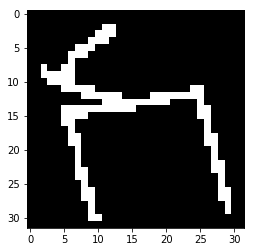

In [8]:
plt.imshow(imgs[2], cmap="gray")

In [9]:
batch_size = 48

In [10]:
np.array(imgs).shape

(37470, 32, 32)

In [11]:
#(X_train, y_train), (X_test, y_test) = mnist.load_data()
(X_train, X_test, y_train, y_test) = train_test_split(np.array(imgs), np.array([0 for _ in range(len(imgs))]), test_size=0.1, random_state=98)

In [12]:
# X_train = X_train[np.where(y_train == 0)[0]]
# y_train = [0 for _ in range(len(np.where(y_train == 0)[0]))]
# X_test = X_test[np.where(y_test == 0)[0]]
# y_test = [0 for _ in range(len(np.where(y_test == 0)[0]))]

In [13]:
X_train.shape

(33723, 32, 32)

In [14]:
X_test.shape

(3747, 32, 32)

In [15]:
# 前処理
X_train = X_train[:X_train.shape[0] // batch_size * batch_size].astype("float32") / 255
X_test = X_test[:X_test.shape[0] // batch_size * batch_size].astype("float32") / 255

train_num, height, width = X_train.shape
test_num = X_test.shape[0]

X_train = X_train.reshape(train_num, height, width, 1)
X_test = X_test.reshape(test_num, height, width, 1)

print(X_train.shape, X_test.shape)

(33696, 32, 32, 1) (3744, 32, 32, 1)


## モデルの構築

In [16]:
K.clear_session()

In [17]:
kernel_size = 3
filters = 32
add_filter_size = 32
n_hidden = 256
z_dim = 2

In [18]:
now = datetime.datetime.now()
str_now = now.strftime('%Y%m%d_%H%M%S')

In [19]:
def sampling(args):
    z_mean, z_log_var = args
    eps = K.random_normal(shape=(K.shape(z_mean)[0],
                                K.int_shape(z_mean)[1]), 
                          mean=0., 
                          stddev=1.0)
    return z_mean + K.exp(0.5 * z_log_var) * eps

In [20]:
# エンコーダ
inputs = Input(shape=(X_train.shape[1:]))
x = inputs

for _ in range(3):
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               activation='relu',
               strides=2,
               padding='same')(x)

    x = BatchNormalization()(x)
    filters += add_filter_size

shape_before_flat = K.int_shape(x)
x = Flatten()(x)

x = Dense(n_hidden, activation="relu")(x)
x = BatchNormalization()(x)
x = Dense(n_hidden//2, activation="relu")(x)


z_mean = Dense(z_dim, name="z_mean")(x)
z_log_var = Dense(z_dim, name="z_log_var")(x)
z = Lambda(sampling, output_shape=(z_dim,), name='z')([z_mean, z_log_var])

encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 16, 16, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 16, 16, 32)   128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 8, 8, 64)     18496       batch_normalization_1[0][0]      
__________________________________________________________________________________________________
batch_norm

In [21]:
# encoder の保存
json_string = encoder.to_json()
with open("../output/conv_vae_encoder_{}.json".format(str_now), "w") as json_model:
    json_model.write(json_string)

In [22]:
# デコーダ
latent_inputs = Input(shape=(z_dim,), name="z_sampling")

z_decoded = Dense(n_hidden//2, activation="relu")(latent_inputs)
z_decoded = BatchNormalization()(z_decoded)
z_decoded = Dense(n_hidden, activation="relu")(latent_inputs)

z_decoded = Dense(np.prod(shape_before_flat[1:]), activation="relu")(z_decoded)
z_decoded = Reshape(shape_before_flat[1:])(z_decoded)

for _ in range(3):
    filters -= add_filter_size
    z_decoded = Conv2DTranspose(filters=filters,
                    kernel_size=kernel_size,
                    activation='relu',
                    strides=2,
                    padding='same')(z_decoded)
    z_decoded = BatchNormalization()(z_decoded)
    
outputs = Conv2DTranspose(filters=1,
          kernel_size=kernel_size,
          activation='sigmoid',
          padding='same',
          name='decoder_output')(z_decoded)   
    
# outputs1 = Conv2DTranspose(filters=1,
#           kernel_size=kernel_size,
#           activation='sigmoid',
#           padding='same',
#           name='decoder_output1')(z_decoded)

# outputs2 = Conv2DTranspose(filters=1,
#           kernel_size=kernel_size,
#           activation='sigmoid',
#           padding='same',
#           name='decoder_output2')(z_decoded)

#decoder = Model(latent_inputs, [outputs1, outputs2], name="decoder")
decoder = Model(latent_inputs, outputs, name="decoder")
decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z_sampling (InputLayer)      (None, 2)                 0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               768       
_________________________________________________________________
dense_5 (Dense)              (None, 1536)              394752    
_________________________________________________________________
reshape_1 (Reshape)          (None, 4, 4, 96)          0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 8, 8, 96)          83040     
_________________________________________________________________
batch_normalization_6 (Batch (None, 8, 8, 96)          384       
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 16, 16, 64)        55360     
__________

In [23]:
# decoder の保存
# encoder の保存
json_string = decoder.to_json()
with open("../output/conv_vae_decoder_{}.json".format(str_now), "w") as json_model:
    json_model.write(json_string)

In [24]:
# VAE model
# outputs_mu, outputs_sigma_2 = decoder(encoder(inputs)[2])
# vae = Model(inputs, [outputs_mu, outputs_sigma_2], name='vae_mlp')
outputs_decoder = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs_decoder, name='vae_mlp')

- kl_loss
    - カルバック・ライブラー情報量
    - 確率論と情報理論を組み合わせた２つの確率分布がどの程度似ているかを表す尺度

$$ loss = \frac{1}{2} \sum^{N_z}_{j=1} (\mu^{2}_{z_j} + \sigma^{2}_{z_j} - \log{\sigma^2_{z_j} - 1}) \\ = \frac{1}{2} \cdot \sum^{N_z}_{j=1} (\mu^{2}_{z_j} + \exp(\log{\sigma}) - \log{\sigma} - 1)?$$

> https://qiita.com/shinmura0/items/811d01384e20bfd1e035

In [25]:
# # loss
# m_vae_loss = (K.flatten(inputs) - K.flatten(outputs_mu))**2 / K.flatten(outputs_sigma_2)
# m_vae_loss = 0.5 * K.sum(m_vae_loss)

# a_vae_loss = K.log(2 * np.pi * K.flatten(outputs_sigma_2))
# a_vae_loss = 0.5 * K.sum(a_vae_loss)

kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.mean(K.sum(kl_loss, axis=-1))
kl_loss *= -0.5

reconstruction_loss = K.sum(binary_crossentropy(K.flatten(inputs), K.flatten(outputs_decoder))) * width * height

vae_loss = reconstruction_loss + kl_loss

In [26]:
# build model
vae.add_loss(vae_loss)
vae.compile(optimizer="rmsprop")
vae.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 1)         0         
_________________________________________________________________
encoder (Model)              [(None, 2), (None, 2), (N 502884    
_________________________________________________________________
decoder (Model)              (None, 32, 32, 1)         553441    
Total params: 1,056,325
Trainable params: 1,055,045
Non-trainable params: 1,280
_________________________________________________________________


### Tensorboardによる監視

In [27]:
!mkdir -p ../tmp

In [28]:
class TensorBoardImage(Callback):
    def __init__(self, model, tag, now):
        super().__init__() 
        self._model = model
        self._tag = tag
        self._now = now
        
    def tf_summary_image(self, img):
        import io
        from PIL import Image
        img = img.astype(np.uint8)
        
        height, width, channel = img.shape if len(img.shape) == 3 else (img.shape[0], img.shape[1], 1)
        
        image = Image.fromarray(img)
        with io.BytesIO() as output:
            
            image.save(output, format="PNG")
            image_string = output.getvalue()
        return tf.Summary.Image(height=height,
                               width=width,
                               colorspace=channel,
                               encoded_image_string=image_string)

    def decode_image(self):
        n = 15 # figure with 15x15 digits
        digit_size = 32
        figure = np.zeros((digit_size * n, digit_size * n))

        grid_x = norm.ppf(np.linspace(0.05, 0.95, n)) 
        grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

        for i, yi in enumerate(grid_x):
            for j, xi in enumerate(grid_y):
                z_sample = np.array([[xi, yi]])
                x_decoded = self._model.predict(z_sample)
                digit = x_decoded[0].reshape(digit_size, digit_size)
                figure[i * digit_size: (i + 1) * digit_size,
                       j * digit_size: (j + 1) * digit_size] = digit
        
        figure *= 255
        return figure
    
    def on_epoch_end(self, epoch, logs={}):
        # Do something to the image
        pose_dist = self.decode_image()
        image = self.tf_summary_image(pose_dist)
        summary = tf.Summary(value=[tf.Summary.Value(tag=self._tag, image=image)])
        with tf.summary.FileWriter('/home/nvidia/Desktop/Research/tmp/conv_vaeimg_{}'.format(str_now)) as writer:
            writer.add_summary(summary, epoch)
            
        return

In [29]:
es_cb = EarlyStopping(monitor='val_loss', patience=10, mode="auto")
tb_cb = TensorBoard(log_dir='/home/nvidia/Desktop/Research/tmp/conv_vaelog_{}'.format(str_now),
                    write_images=True, 
                    write_grads=True, 
                    write_graph=True)
mc_cb = ModelCheckpoint("/home/nvidia/Desktop/Research/output/conv_vae_best_param.hdf5",
                       monitor="val_loss",
                       verbose=1,
                       save_best_only=True,
                       mode="auto")
tbi_cb = TensorBoardImage(decoder, "pose distribution", str_now)
print(str_now)

20190107_074233


In [30]:
cbks = [es_cb, tb_cb, mc_cb, tbi_cb]

### 学習

In [31]:
n_epochs = 10

In [32]:
vae.save_weights("../output/conv_vae_init_param_{}.hdf5".format(str_now))

In [33]:
json_string = vae.to_json()
with open("../output/conv_vae_model_{}.json".format(str_now), "w") as json_model:
    json_model.write(json_string)

In [34]:
#vae.load_weights("../output/vae_best_param_20181223_135142.hdf5")

In [35]:
history = vae.fit(X_train,
        shuffle=True,
        epochs=n_epochs,
        batch_size=batch_size,
        validation_data=(X_test, None),
        verbose=0,
        callbacks=cbks)


Epoch 00001: val_loss improved from inf to 213.02050, saving model to /home/nvidia/Desktop/Research/output/conv_vae_best_param.hdf5

Epoch 00002: val_loss improved from 213.02050 to 197.22760, saving model to /home/nvidia/Desktop/Research/output/conv_vae_best_param.hdf5

Epoch 00003: val_loss improved from 197.22760 to 185.21028, saving model to /home/nvidia/Desktop/Research/output/conv_vae_best_param.hdf5

Epoch 00004: val_loss improved from 185.21028 to 180.76455, saving model to /home/nvidia/Desktop/Research/output/conv_vae_best_param.hdf5

Epoch 00005: val_loss improved from 180.76455 to 173.68822, saving model to /home/nvidia/Desktop/Research/output/conv_vae_best_param.hdf5

Epoch 00006: val_loss improved from 173.68822 to 172.87242, saving model to /home/nvidia/Desktop/Research/output/conv_vae_best_param.hdf5

Epoch 00007: val_loss improved from 172.87242 to 169.00068, saving model to /home/nvidia/Desktop/Research/output/conv_vae_best_param.hdf5

Epoch 00008: val_loss did not im

In [36]:
vae.save_weights("../output/conv_vae_best_param_{}.hdf5".format(str_now))

In [37]:
encoder.save_weights("../output/conv_vae_encoder_best_param_{}.hdf5".format(str_now))

In [38]:
decoder.save_weights("../output/conv_vae_decoder_best_param_{}.hdf5".format(str_now))

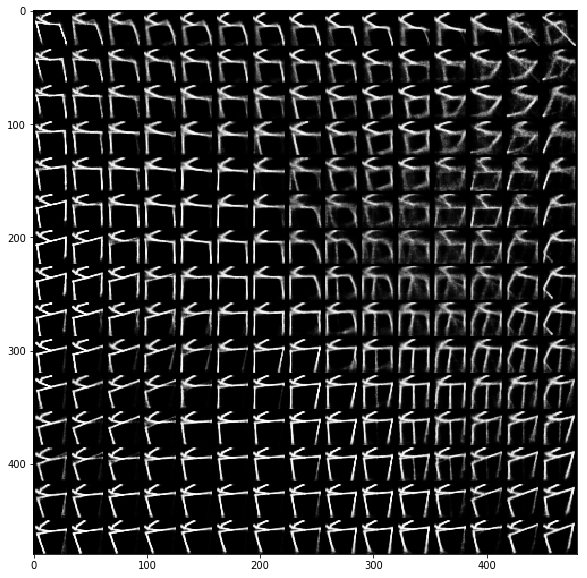

In [39]:
# display a 2D manifold of the digits
# 0 に対して分布を見てみる
n = 15 # figure with 15x15 digits
digit_size = 32
figure = np.zeros((digit_size * n, digit_size * n))

grid_x = norm.ppf(np.linspace(0.05, 0.95, n)) 
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()

## 潜在変数への変換

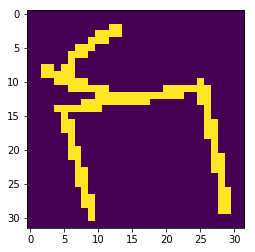

In [40]:
plt.imshow(imgs[2])

In [41]:
X_test[:3].shape

(3, 32, 32, 1)

In [42]:
encode_pred = encoder.predict(X_test[:3])[0]

In [43]:
encode_pred

array([[-0.17526083,  1.1645154 ],
       [-0.9859896 , -1.5292317 ],
       [ 0.87016815,  0.5489261 ]], dtype=float32)

In [44]:
encode_pred[0]

array([-0.17526083,  1.1645154 ], dtype=float32)

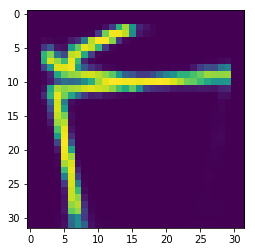

In [45]:
plt.imshow(decoder.predict(np.array([encode_pred[0]]))[0].reshape(32, 32))

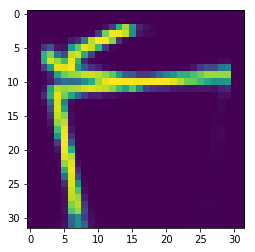

In [46]:
plt.imshow(vae.predict(X_test[:3])[0].reshape(32,32))

In [17]:
with open("../output/conv_vae_model_20190107_074233.json") as f:
    json_string = f.readline()

In [18]:
from keras.models import model_from_json

In [19]:
vae = model_from_json(json_string)
vae.load_weights("../output/conv_vae_best_param_20190107_074233.hdf5")

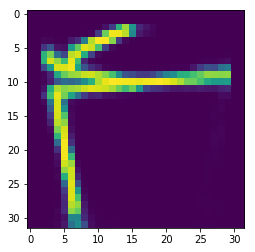

In [20]:
plt.imshow(vae.predict(X_test[:3])[0].reshape(32,32))

## まとめ
VAEによる1種類の生成モデルを学習させることで1枚の画像の分布を得ることができるのでこれを用いて画像比較ができる。